In [38]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
from PIL import Image

## Load data

In [52]:
masks = sorted(glob.glob(r"C:\Users\92035\Music\Amemoire\Ki67_preprocess\ki67_manual\train\stain_transform_ki67_new\stained_label\*.png"))
orgs = sorted(glob.glob(r"C:\Users\92035\Music\Amemoire\Ki67_preprocess\ki67_manual\train\stain_transform_ki67_new\stained_image\*.png"))

In [53]:
imgs_list = []
masks_list = []
for image, mask in zip(orgs, masks):
    imgs_list.append(np.array(Image.open(image).resize((512,512))))
    
    im = Image.open(mask).resize((512,512))
    #width, height = im.size   # Get dimensions

    #left = (width - 388)/2
    #top = (height - 388)/2
    #right = (width + 388)/2
    #bottom = (height + 388)/2

    #im_cropped = im.crop((left, top, right, bottom))
    masks_list.append(np.array(im))

imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

In [54]:
print(imgs_np.shape, masks_np.shape)

(96, 512, 512, 3) (96, 512, 512)


## Plot images + masks + overlay (mask over original)

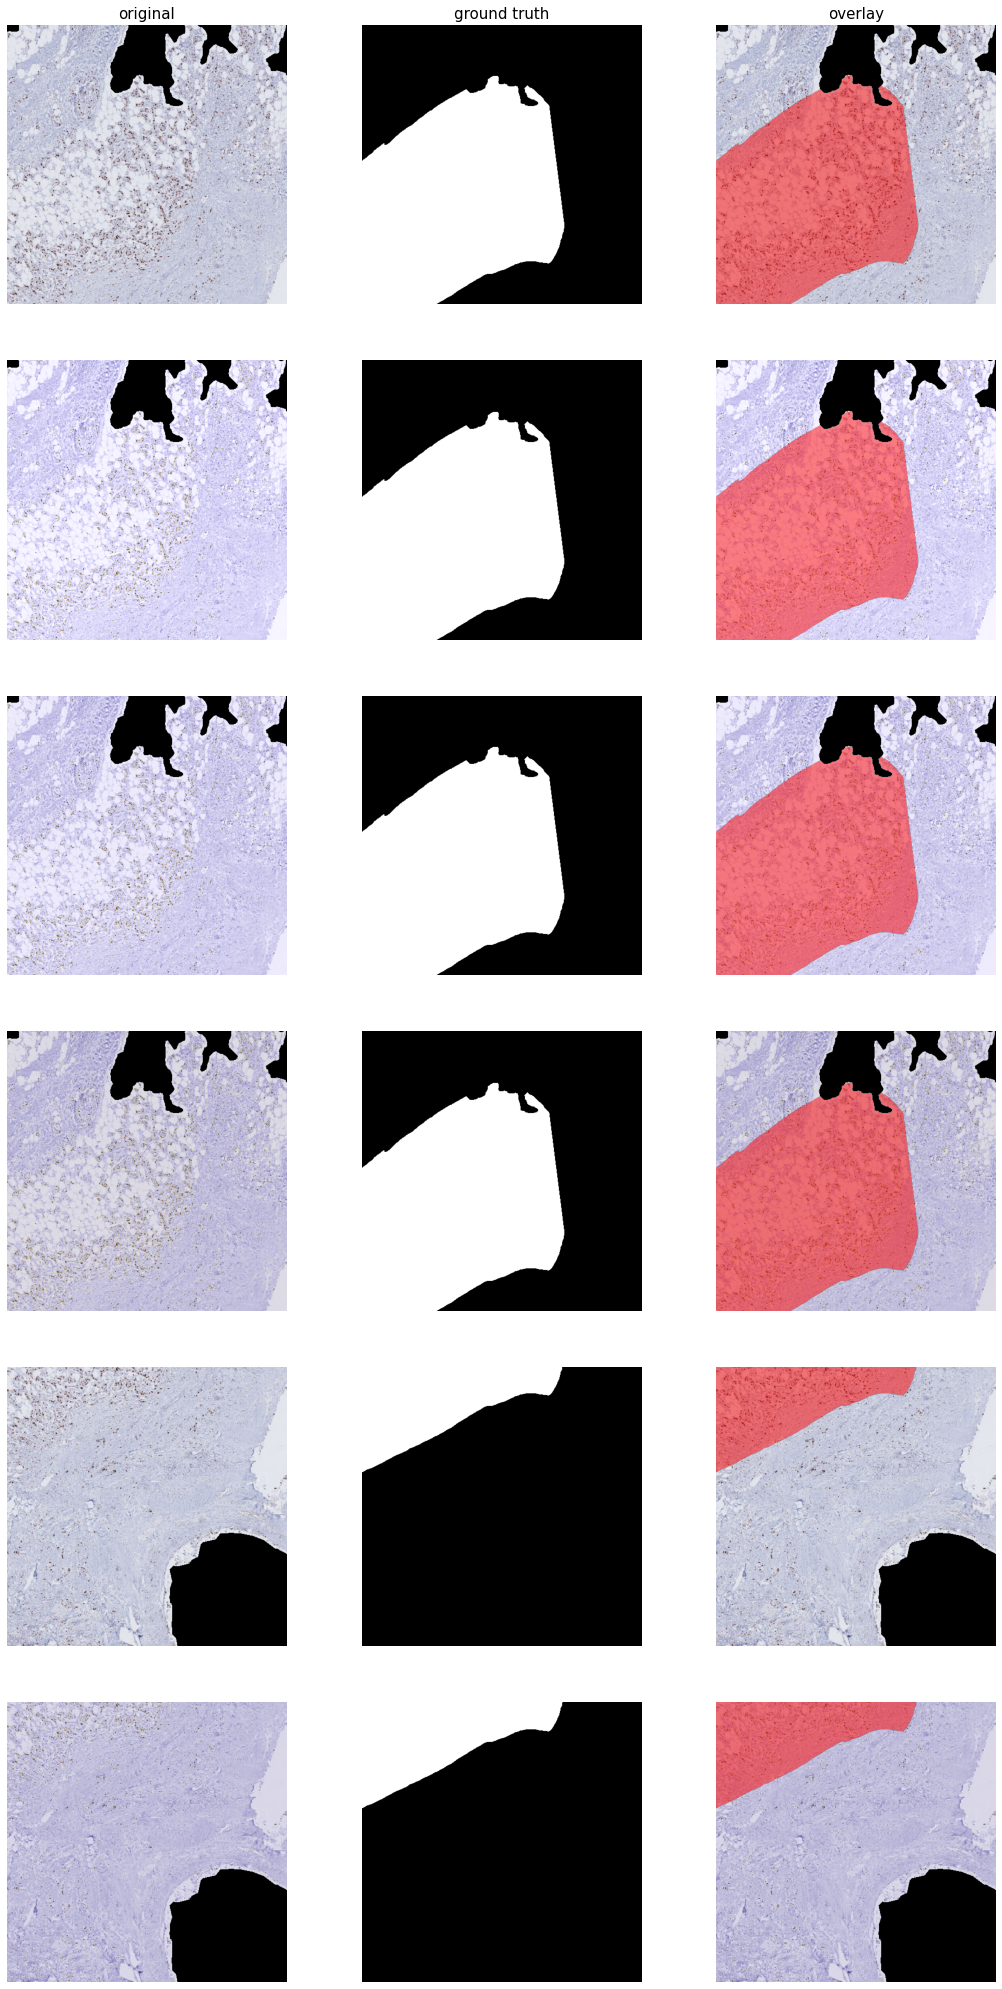

In [55]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=imgs_np, mask_imgs=masks_np, nm_img_to_plot=6, figsize=6)


## Get data into correct shape, dtype and range (0.0-1.0)

In [56]:
print(imgs_np.max(), masks_np.max())

255 1


In [57]:
x = np.asarray(imgs_np, dtype=np.float32)/255
y = np.asarray(masks_np, dtype=np.float32)

In [58]:
print(x.max(), y.max())

1.0 1.0


In [59]:
print(x.shape, y.shape)

(96, 512, 512, 3) (96, 512, 512)


In [60]:
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
print(x.shape, y.shape)

(96, 512, 512, 3) (96, 512, 512, 1)


In [61]:
# x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
# print(x.shape, y.shape)

##  Train/val split

In [62]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (76, 512, 512, 3)
y_train:  (76, 512, 512, 1)
x_val:  (20, 512, 512, 3)
y_val:  (20, 512, 512, 1)


## Prepare train generator with data augmentation

In [63]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
#         width_shift_range=0.05,
#         height_shift_range=0.05,
#         shear_range=50,
#         zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

(2, 512, 512, 3) (2, 512, 512, 1)


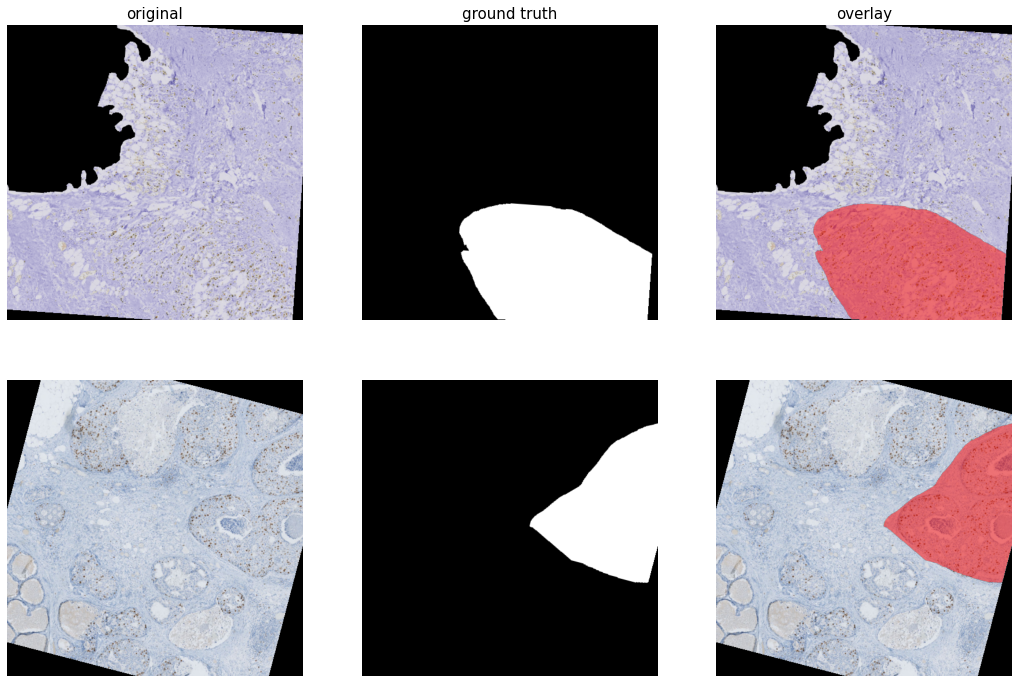

In [64]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=4, figsize=6)

## Initialize network

In [30]:
from keras_unet.models import custom_unet

input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 spatial_dropout2d (SpatialDrop  (None, 512, 512, 64  0          ['conv2d[0][0]']                 
 out2D)                         )                                                             

In [33]:
import os
os.environ["PATH"] += os.pathsep + "C:\\Program Files (x86)\\Graphviz2.38\\bin\\"

In [ ]:
import sys
print(sys.path)

sys.path.append("C:\\Program Files (x86)\\Graphviz2.38\\bin\\") 

print(sys.path)

In [32]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

ImportError: cannot import name 'plot_model' from 'keras.utils' (C:\Users\92035\anaconda3\envs\keras-unet\lib\site-packages\keras\utils\__init__.py)

## Compile + train

In [33]:
from keras.callbacks import ModelCheckpoint


model_filename = 'segm_model_v0.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [36]:
from tensorflow.keras.optimizers import SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    #optimizer=Adam(), 
    optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)


C:\Users\92035\anaconda3\envs\keras-unet\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [37]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=10,
    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

C:\Users\92035\AppData\Local\Temp/ipykernel_53396/3634559958.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.3984 - iou: 0.1277 - iou_thresholded: 0.0058 
Epoch 00001: val_loss improved from inf to 0.37277, saving model to segm_model_v0.h5
100/100 [==============================] - 1934s 19s/step - loss: 0.3984 - iou: 0.1277 - iou_thresholded: 0.0058 - val_loss: 0.3728 - val_iou: 0.1345 - val_iou_thresholded: 1.1306e-06
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.4444 - iou: 0.1050 - iou_thresholded: 0.0184 
Epoch 00002: val_loss did not improve from 0.37277
100/100 [==============================] - 2004s 20s/step - loss: 0.4444 - iou: 0.1050 - iou_thresholded: 0.0184 - val_loss: 0.4100 - val_iou: 0.0950 - val_iou_thresholded: 1.1306e-06
Epoch 3/10
 94/100 [===========================>..] - ETA: 1:49 - loss: nan - iou: nan - iou_thresholded: 0.0140

KeyboardInterrupt: 

## Plot training history

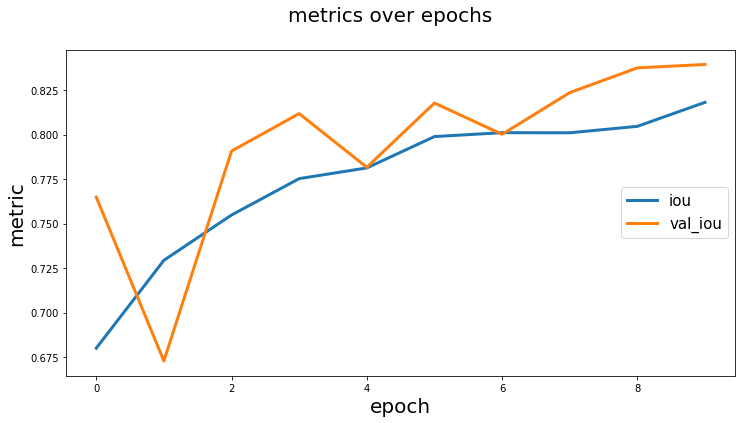

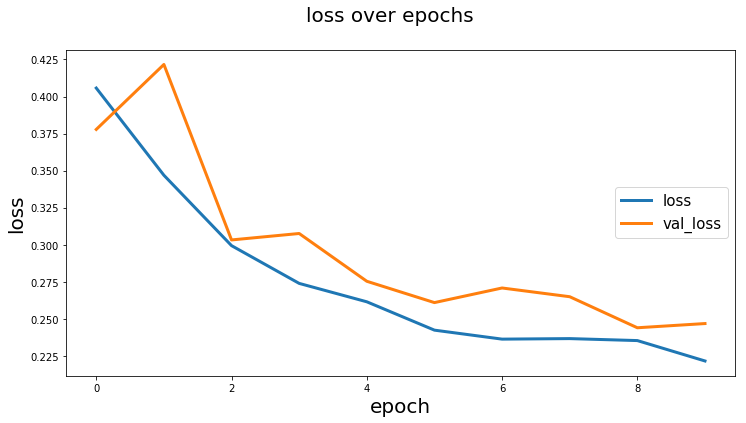

In [45]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

## Plot original + ground truth + pred + overlay (pred on top of original)

In [17]:
model.load_weights(model_filename)
y_pred = model.predict(x_val)

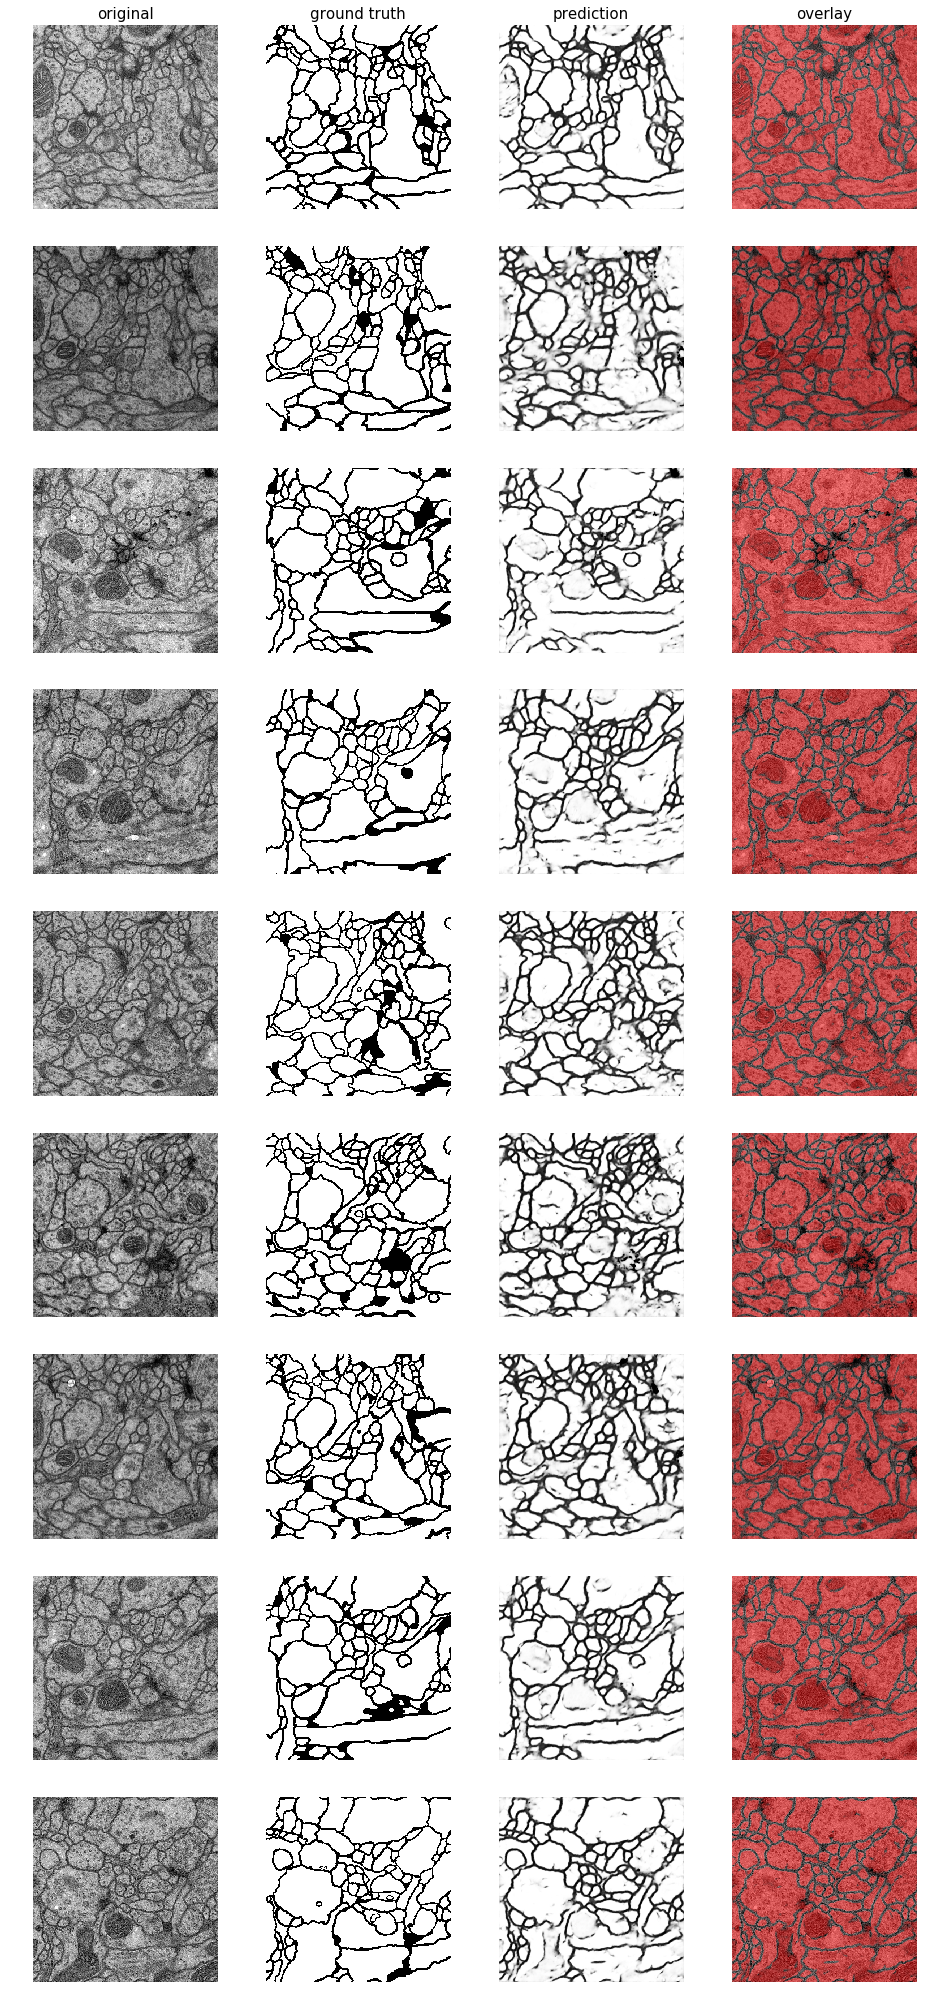

In [18]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=9)